# Etude de la Varicelle

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

Le jeu de données se trouve sur le site [Réseau Sentinelles](http://www.sentiweb.fr/).
Nous le téléchargeons en local.


In [2]:
import urllib.request
import os

data_url = "https://www.sentiweb.fr/datasets/incidence-PAY-7.csv"
data_file = "varicelle.csv"

if not os.path.isfile(data_file):
    urllib.request.urlretrieve(data_url, data_file)


Voici l'explication des colonnes données [sur le site d'origine](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):

| Nom de colonne | Libellé de colonne                                                                                                                |
|----------------|-----------------------------------------------------------------------------------------------------------------------------------|
| week           | Semaine calendaire (ISO 8601)                                                                                                     |
| indicator      | Code de l'indicateur de surveillance                                                                                              |
| inc            | Estimation de l'incidence de consultations en nombre de cas                                                                       |
| inc_low        | Estimation de la borne inférieure de l'IC95% du nombre de cas de consultation                                                     |
| inc_up         | Estimation de la borne supérieure de l'IC95% du nombre de cas de consultation                                                     |
| inc100         | Estimation du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants)                                   |
| inc100_low     | Estimation de la borne inférieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| inc100_up      | Estimation de la borne supérieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| geo_insee      | Code de la zone géographique concernée (Code INSEE) http://www.insee.fr/fr/methodes/nomenclatures/cog/                            |
| geo_name       | Libellé de la zone géographique (ce libellé peut être modifié sans préavis)                                                       |

La première ligne du fichier CSV est un commentaire, que nous ignorons en précisant `skiprows=1`.

## Chargement des données

In [3]:
raw_data = pd.read_csv(data_file, skiprows=1)
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202014          7   3881     2223    5539       6           3   
1     202013          7   7341     5247    9435      11           8   
2     202012          7   8123     5790   10456      12           8   
3     202011          7  10198     7568   12828      15          11   
4     202010          7   9011     6691   11331      14          10   
5     202009          7  13631    10544   16718      21          16   
6     202008          7  10424     7708   13140      16          12   
7     202007          7   8959     6574   11344      14          10   
8     202006          7   9264     6925   11603      14          10   
9     202005          7   8505     6314   10696      13          10   
10    202004          7   7991     5831   10151      12           9   
11    202003          7   5968     4100    7836       9           6   
12    202002          7   6534     4530    8538      10           7   
13    202001          7   9835     7019   12651      15          11   
14    201952          7   7941     5246   10636      12           8   
15    201951          7   5823     3675    7971       9           6   
16    201950          7   6424     4276    8572      10           7   
17    201949          7   6621     4540    8702      10           7   
18    201948          7   5542     3383    7701       8           5   
19    201947          7   7536     5058   10014      11           7   
20    201946          7   2638     1316    3960       4           2   
21    201945          7   4492     2615    6369       7           4   
22    201944          7   5728     3627    7829       9           6   
23    201943          7   4834     2751    6917       7           4   
24    201942          7   6279     3989    8569      10           7   
25    201941          7   4130     2030    6230       6           3   
26    201940          7   4211     2218    6204       6           3   
27    201939          7   3137     1310    4964       5           2   
28    201938          7   3078     1416    4740       5           2   
29    201937          7    970      162    1778       1           0   
...      ...        ...    ...      ...     ...     ...         ...   
1501  199126          7  17608    11304   23912      31          20   
1502  199125          7  16169    10700   21638      28          18   
1503  199124          7  16171    10071   22271      28          17   
1504  199123          7  11947     7671   16223      21          13   
1505  199122          7  15452     9953   20951      27          17   
1506  199121          7  14903     8975   20831      26          16   
1507  199120          7  19053    12742   25364      34          23   
1508  199119          7  16739    11246   22232      29          19   
1509  199118          7  21385    13882   28888      38          25   
1510  199117          7  13462     8877   18047      24          16   
1511  199116          7  14857    10068   19646      26          18   
1512  199115          7  13975     9781   18169      25          18   
1513  199114          7  12265     7684   16846      22          14   
1514  199113          7   9567     6041   13093      17          11   
1515  199112          7  10864     7331   14397      19          13   
1516  199111          7  15574    11184   19964      27          19   
1517  199110          7  16643    11372   21914      29          20   
1518  199109          7  13741     8780   18702      24          15   
1519  199108          7  13289     8813   17765      23          15   
1520  199107          7  12337     8077   16597      22          15   
1521  199106          7  10877     7013   14741      19          12   
1522  199105          7  10442     6544   14340      18          11   
1523  199104          7   7913     4563   11263      14           8   
1524  199103          7  15387    10484   20290      27          18   
1525  199102          7  16277  

## Vérification des données

Y a-t-il des points manquants dans ce jeux de données ? NON

In [4]:
raw_data[raw_data.isnull().any(axis=1)]
# pour maintenir la cohérence avec la source (cas grippe)
data = raw_data.copy()

Le format de semaine n'est pas standard. Nous créons une fonction de conversion qui permettra d'utiliser les outils pandas et python classique

In [5]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Tri des données et utilisation de la semaine comme index

In [6]:
sorted_data = data.set_index('period').sort_index()

Vérification de l'écart entre les semaines dans la base : le jeu est complet

In [7]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

## Etude des données

Un premier regard en zoomant sur les 200 dernières semaines. Les cas sont cycliques avec un minimum en fin d'été

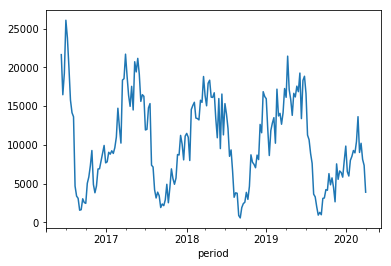

In [8]:
sorted_data['inc'][-200:].plot()

Afin de faire une analyse statistique par année, il faut changer le début de l'année. On pourrait chercher la position moyenne des minima mais l'exercice demande à ce que cela soit la semaine du 1er septembre. 
Les données pour 1990 (première année) commence en décembre, donc on va travailler à partir de 1991.
2020 est incomplète et il faut également l'enlever.

Le bloc suivant calcule la liste des semaines (période) incluant le 1er septembre

In [9]:
first_sept_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

A partir de cette liste, nous fabricons la liste des incidences de chaque année (one_year qui va de sem(année N)  à sem(année N+1) -1,   
puis vérifions qu'elle contient 51 ou 52 semaines (assert ...),  
puis calculons la somme des occurences (yearly incidence),  
en paralallèle nous créeons un 2ème tableau qui contient les nom des années.
A la fin, nous convertissons les 2 tableaux en une série numpy avec les années comme indice et les occurences comme data

In [10]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_sept_week[:-1],
                        first_sept_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

Voilà les incidences annuelles


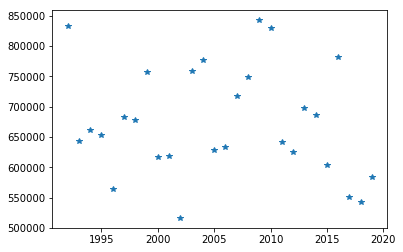

In [11]:
yearly_incidence.plot(style='*')

La question porte sur les années avec le plus et le moins de varicelle.
numpy fournit des fonctions pour cela.

L'année avec le moins de varicelle a été : 

In [12]:
yearly_incidence.idxmin()

2002

L'année avec le plus de varicelle a été : 

In [13]:
yearly_incidence.idxmax()

2009